# 캘리포니아 부동산 가격 예측하기

## library import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## 1. Data
이번 실습에서 사용할 데이터는 california 집 값을 예측하는 데이터입니다.

### 1.1 Data Load
데이터는 `sklearn.datasets`의 `fetch_california_housing`를 통해 사용할 수 있습니다.

In [4]:
housing = fetch_california_housing()

In [5]:
data, target = housing.data, housing.target

In [6]:
data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

### 1.2 Data EDA

In [7]:
housing_df = pd.DataFrame(data, columns=housing.feature_names)
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [9]:
housing_df["target"] = target
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [11]:
housing_df["target"].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64

In [12]:
# dataframe의 columns 이름 추출
col_names = housing_df.columns
col_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

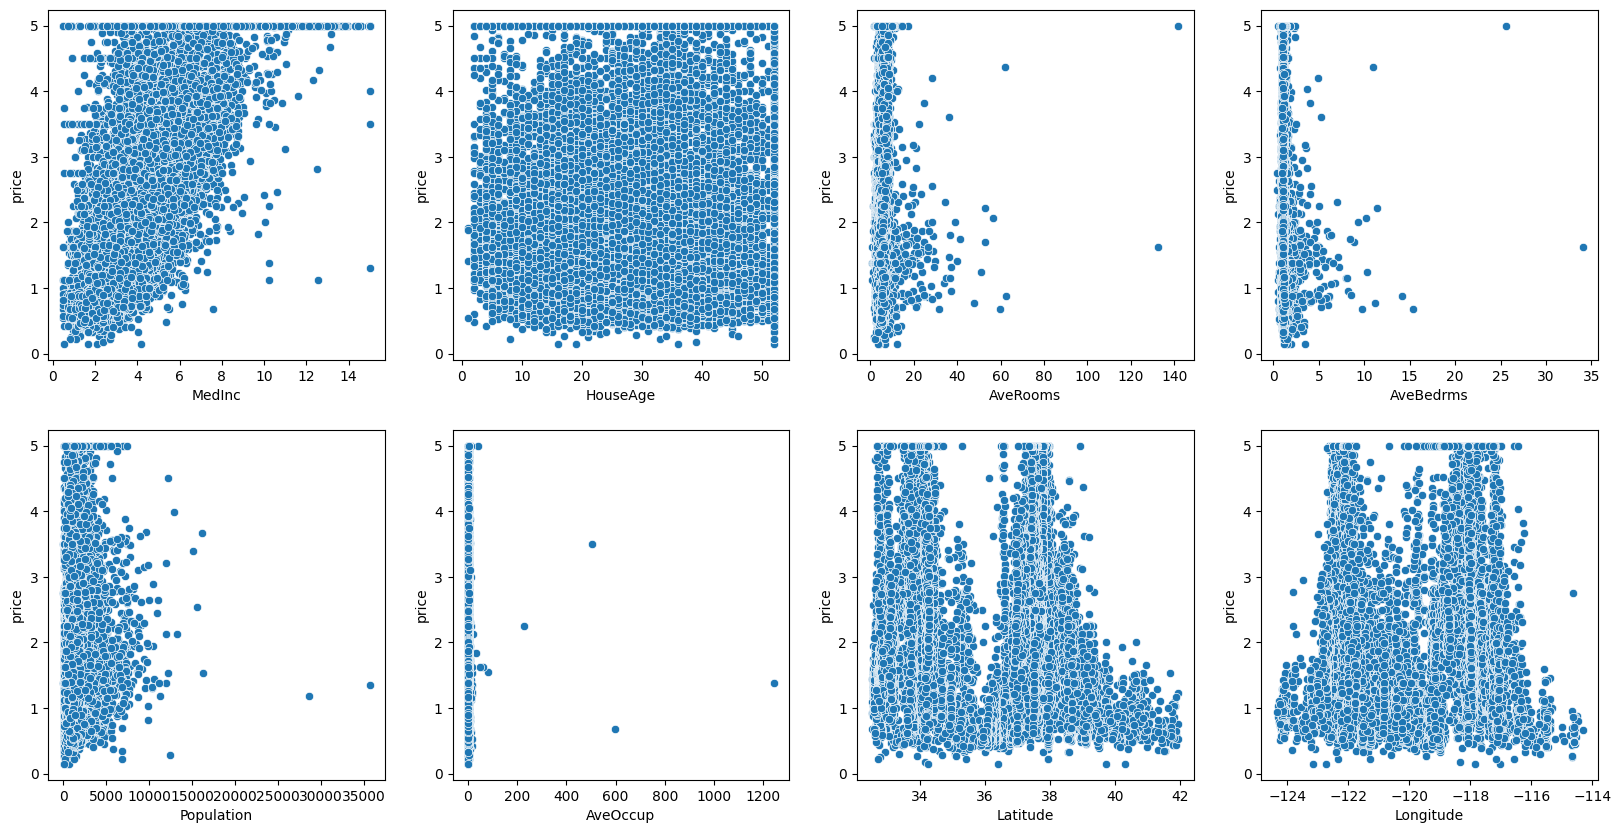

In [13]:
# 각 feature와 target 간의 분포와 관계 살펴보기

figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i in range(len(col_names)-1):
    # ax.scatter(x축, y축)
    fig = sns.scatterplot(data=housing_df, x=col_names[i], y=target, ax=axes[i // 4][i%4])
    fig.set_xlabel(col_names[i])
    fig.set_ylabel("price")

## 상관관계 시각화

In [14]:
corr_df = housing_df.corr()
corr_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650


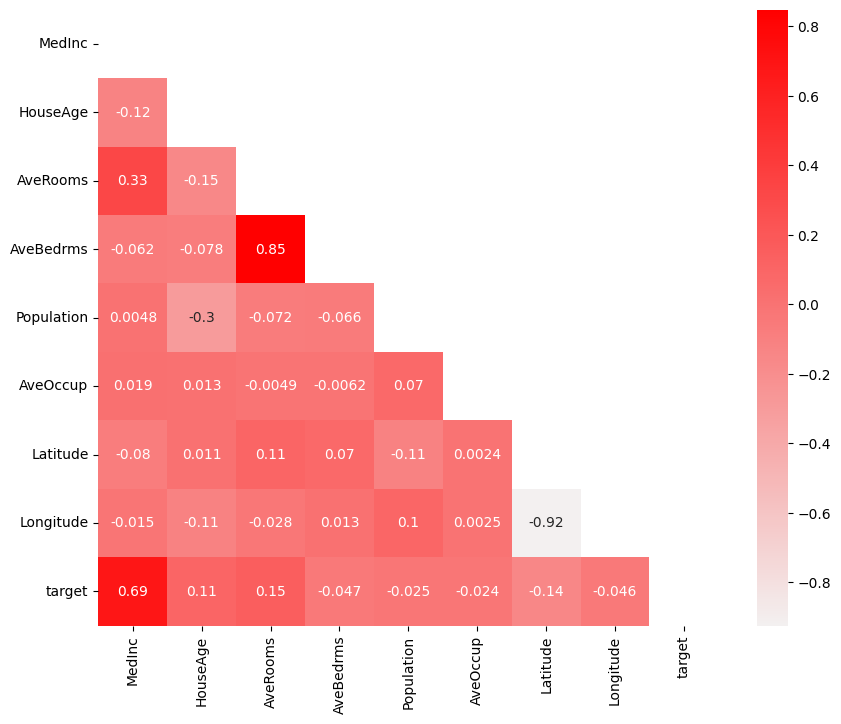

In [15]:
plt.figure(figsize=(10, 8))
# 대각선 방향이 안 되도록 함

mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df,
            cmap=sns.light_palette("red", as_cmap=True),
            annot=True,
            mask=mask
           )
plt.show()

## feature 엔지니어링
- feature selection

### **feature selection**

In [16]:
housing_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [17]:
housing_df_sel = housing_df.drop(["Latitude", "Longitude"], axis=1)
housing_df_sel.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


### 1.3 Data Split

In [18]:
X = housing_df_sel.drop("target", axis=1)
y = housing_df_sel["target"]

In [19]:
X.shape, y.shape

((20640, 6), (20640,))

In [20]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.3, random_state=2023
)

## 2. XGBoost

In [21]:
xgb_reg = xgb.XGBRegressor()

### 2.1 학습

In [22]:
xgb_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 2.2 예측

In [23]:
xgb_train_pred = xgb_reg.predict(train_X)
xgb_test_pred = xgb_reg.predict(test_X)

Text(0, 0.5, 'target')

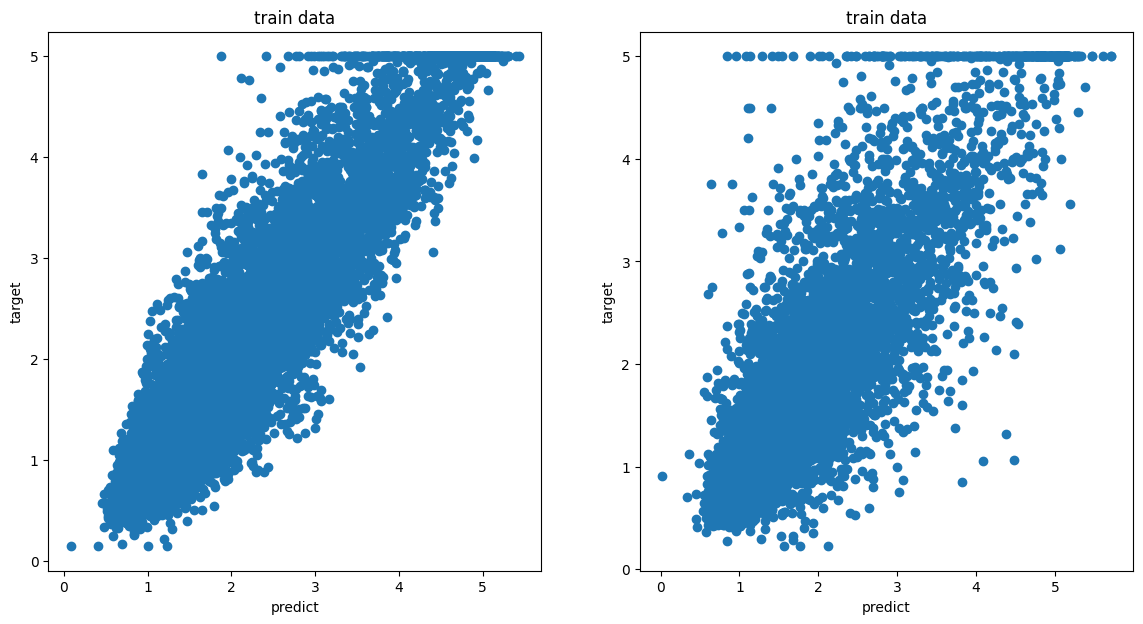

In [24]:
plt.figure(figsize=(14, 7))

plt.subplot(121)
plt.scatter(xgb_train_pred, train_y)
plt.title("train data")
plt.xlabel("predict")
plt.ylabel("target")

plt.subplot(122)
plt.scatter(xgb_test_pred, test_y)
plt.title("train data")
plt.xlabel("predict")
plt.ylabel("target")


### 2.3 평가

In [25]:
xgb_train_mse = mean_squared_error(train_y, xgb_train_pred)
xgb_test_mse = mean_squared_error(test_y, xgb_test_pred)

In [26]:
print(f"XGBoost Train MSE is {xgb_train_mse:.4f}")
print(f"XGBoost Test MSE is {xgb_test_mse:.4f}")

XGBoost Train MSE is 0.1856
XGBoost Test MSE is 0.4363


In [27]:
# RMSE 계산
RMSE = np.sqrt(xgb_train_mse)
test_RMSE = np.sqrt(xgb_test_mse)

In [28]:
print('RMSE :', RMSE)
print('RMSE :', test_RMSE)

RMSE : 0.4307976367874016
RMSE : 0.6604942779435088


## 3. Light GBM

In [29]:
# import lightgbm as lgb
# lgb_reg = lgb.LGBMRegressor()

from lightgbm import LGBMRegressor
lgb_reg = LGBMRegressor()

### 3.1 학습

In [30]:
lgb_reg.fit(train_X, train_y)

LGBMRegressor()

### 3.2 예측

In [31]:
lgb_train_pred = lgb_reg.predict(train_X)
lgb_test_pred = lgb_reg.predict(test_X)

Text(0, 0.5, 'target')

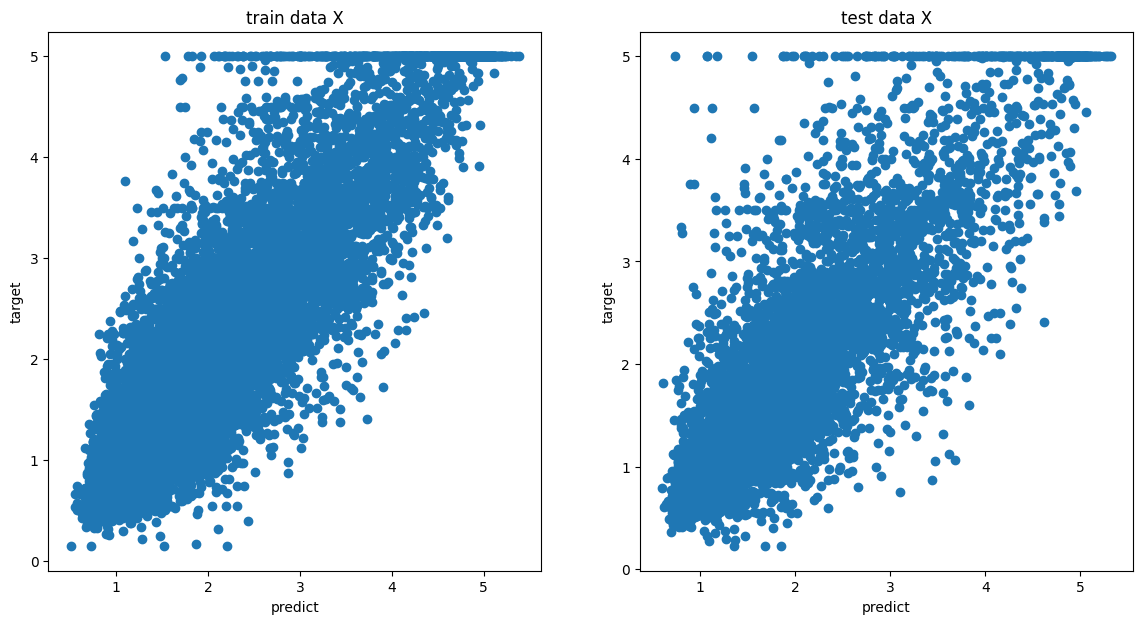

In [32]:
plt.figure(figsize=(14, 7))

plt.subplot(121)
plt.scatter(lgb_train_pred, train_y)
plt.title("train data X")
plt.xlabel("predict")
plt.ylabel("target")

plt.subplot(122)
plt.scatter(lgb_test_pred, test_y)
plt.title("test data X")
plt.xlabel("predict")
plt.ylabel("target")

### 3.3 평가

In [33]:
lgb_train_mse = mean_squared_error(train_y, lgb_train_pred)
lgb_test_mse = mean_squared_error(test_y, lgb_test_pred)

In [34]:
print(f"Light Boost Train MSE is {lgb_train_mse:.4f}")
print(f"Light Boost Test MSE is {lgb_test_mse:.4f}")

Light Boost Train MSE is 0.2956
Light Boost Test MSE is 0.4089


In [35]:
# RMSE 계산
train_RMSE_lgb = np.sqrt(lgb_train_mse)
test_RMSE_lgb = np.sqrt(lgb_test_mse)

In [36]:
print('RMSE :', train_RMSE_lgb)
print('RMSE :', test_RMSE_lgb)

RMSE : 0.5436548483967198
RMSE : 0.6394220793784139


## 4. 마무리

In [37]:
print(f"XGBoost Test MSE is {xgb_test_mse:.4f}")
print(f"Light Boost Test MSE is {lgb_test_mse:.4f}")

XGBoost Test MSE is 0.4363
Light Boost Test MSE is 0.4089


# R2 score(결정 계수: R-squared)
- Regression 문제 해결 평가 중 하나
- 독립 변수가 종속 변수를 얼마나 잘 설명해주는지 보여주는 지표
    - 1: 좋은 회귀 모델
    - 0: 나쁜 모델
    - -(음수) : 사용 불가 모델

In [38]:
from sklearn.metrics import r2_score

print("r2_score: {}".format(r2_score(test_y, lgb_test_pred)))

r2_score: 0.6956510571230312


## [mission]
- 이상치 확인
- 어떤 스케일링을 하면 좋을 결정 / 적용
    - MinMaxScaling
    - StandardScaling
    - RobustScaler
    - MaxAbsScaler
    - Normalizer

In [39]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [40]:
xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
xgb_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
print('모델의 정확도 :', round(xgb_reg.score(test_X, test_y), 4))

모델의 정확도 : 0.6753


## MinMaxScaling (정규화; normalization)
- from sklearn.preprocessing import MinMaxScaler

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
mms = MinMaxScaler()
mms.fit(train_X)
X_train_scaled = mms.transform(train_X)
X_test_scaled = mms.transform(test_X)
xgb_reg.fit(X_train_scaled, train_y)
print('모델의 정확도 :', round(xgb_reg.score(X_test_scaled, test_y), 4))

모델의 정확도 : 0.6752


## StandardScaling (표준화; standardization)

In [50]:
from sklearn.preprocessing import StandardScaler

In [52]:
std = StandardScaler()
std.fit(train_X)
X_train_scaled = std.transform(train_X)
X_test_scaled = std.transform(test_X)

xgb_reg.fit(X_train_scaled, train_y)
print('모델의 정확도 :', round(xgb_reg.score(X_test_scaled, test_y), 4))

모델의 정확도 : 0.6751


## RobustScaler

In [53]:
from sklearn.preprocessing import RobustScaler

In [55]:
rbs = RobustScaler()
X_train_scaled = rbs.fit_transform(train_X)
X_test_scaled = rbs.transform(test_X)
xgb_reg.fit(X_train_scaled, train_y)
print('모델의 정확도 :', round(xgb_reg.score(X_test_scaled, test_y), 4))

모델의 정확도 : 0.6753


## MaxAbsScaler

In [56]:
from sklearn.preprocessing import MaxAbsScaler

In [62]:
mas = MaxAbsScaler()

In [87]:
mas.fit(housing_df_sel)

scaled_mas = mas.transform(housing_df_sel)

In [88]:
scaled_df = pd.DataFrame(scaled_mas, columns=housing_df_sel.columns)
scaled_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,target
0,0.555010,0.788462,0.049216,0.030053,0.009024,0.002055,0.905198
1,0.553423,0.403846,0.043959,0.028529,0.067289,0.001697,0.716999
2,0.483823,1.000000,0.058405,0.031510,0.013901,0.002254,0.704199
3,0.376204,1.000000,0.040994,0.031499,0.015638,0.002049,0.682599
4,0.256412,1.000000,0.044267,0.031734,0.015834,0.001755,0.684399


In [89]:
X = scaled_df.drop(["target"], axis=1)

In [90]:
y = scaled_df["target"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [92]:
mas_scaled = MaxAbsScaler()

mas_scaled.fit(X_train)
X_train_scaled = mas_scaled.transform(X_train)
X_test_scaled = mas_scaled.transform(X_test)

xgb_reg.fit(X_train_scaled, y_train)
print('모델의 정확도 :', round(xgb_reg.score(X_test_scaled, y_test), 4))

모델의 정확도 : 0.6708


In [93]:
lgb_reg = LGBMRegressor()

In [94]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor()

In [95]:
lgb_train_pred = lgb_reg.predict(X_train)
lgb_test_pred = lgb_reg.predict(X_test)

In [99]:
mas_train_mse = mean_squared_error(y_train, lgb_train_pred)
mas_test_mse = mean_squared_error(y_test, lgb_test_pred)

print(f"Light GBM Train MSE is {mas_train_mse:.4f}")
print(f"Light GBM Test MSE is {mas_test_mse:.4f}")

Light GBM Train MSE is 0.0121
Light GBM Test MSE is 0.0165


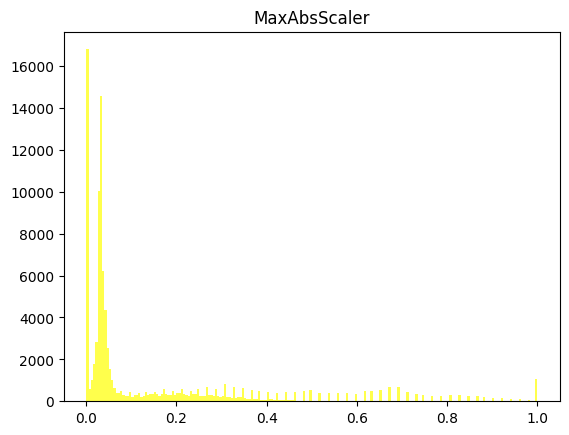

In [97]:
X_train_scaled_mas = X_train_scaled.reshape(-1,1)
plt.hist(X_train_scaled_mas, bins=200, color='yellow', alpha = 0.7)
plt.title('MaxAbsScaler')
plt.show()

In [98]:
from sklearn.metrics import r2_score

print("r2_score: {}".format(r2_score(y_test, lgb_test_pred)))

r2_score: 0.6998401715688982


## Normalizer

In [59]:
from sklearn.preprocessing import Normalizer

In [60]:
norm = Normalizer()
X_train_scaled = norm.fit_transform(train_X)
X_test_scaled = norm.transform(test_X)
xgb_reg.fit(X_train_scaled, train_y)
print('모델의 정확도 :', round(xgb_reg.score(X_test_scaled, test_y), 4))

모델의 정확도 : 0.6282
